## **Fine-tuning BERT for named-entity recognition**

In this notebook, we are going to use [**AutoModelForTokenClassification**](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForTokenClassification) which is included in the [Transformers library](https://github.com/huggingface/transformers) by HuggingFace. This model has a Transformer as its base architecture, with a token classification head on top, allowing it to make predictions at the token level, rather than the sequence level. **Named entity recognition (NER)** is typically treated as a token classification problem, so that's what we are going to use it for.

This tutorial uses the idea of **transfer learning**, i.e. first pretraining a large neural network in an unsupervised way, and then fine-tuning that neural network on a task of interest. In this case, BERT is a neural network pretrained on t tasks: masked language modeling and next sentence prediction. Now, we are going to fine-tune this network on a NER dataset. Fine-tuning is supervised learning, so this means we will need a labeled dataset.

If you want to know more about BERT, I suggest the following resources:
* the original [paper](https://arxiv.org/abs/1810.04805)
* Jay Allamar's [blog post](http://jalammar.github.io/illustrated-bert/) as well as his [tutorial](http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/)
* Chris Mccormick's [Youtube channel](https://www.youtube.com/channel/UCoRX98PLOsaN8PtekB9kWrw)
* Abbishek Kumar Mishra's [Youtube channel](https://www.youtube.com/user/abhisheksvnit)

The following notebook largely follows the same structure as the tutorials by Abhishek Kumar Mishra. For his tutorials on the Transformers library, see his [Github repository](https://github.com/abhimishra91/transformers-tutorials).

> NOTE: this notebook assumes basic knowledge about deep learning, BERT, and native PyTorch. If you want to learn more Python, deep learning and PyTorch, I highly recommend [cs224n](https://web.stanford.edu/class/cs224n/) by Stanford University and the [FastAI course](https://course.fast.ai/) by Jeremy Howard et al. Both are freely available on the web.  

Now, let's move on to the real stuff!

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification

In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cpu


#### **Downloading and preprocessing the data**
Named entity recognition (NER) uses a specific annotation scheme, which is defined (at least for European languages) at the *word* level. An annotation scheme that is widely used is called **[IOB-tagging](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)**, which stands for Inside-Outside-Beginning. Each tag indicates whether the corresponding word is *inside*, *outside* or at the *beginning* of a specific named entity. The reason this is used is because named entities usually comprise more than 1 word.

Let's have a look at an example. If you have a sentence like "Barack Obama was born in Hawaï", then the corresponding tags would be   [B-PERS, I-PERS, O, O, O, B-GEO]. B-PERS means that the word "Barack" is the beginning of a person, I-PERS means that the word "Obama" is inside a person, "O" means that the word "was" is outside a named entity, and so on. So one typically has as many tags as there are words in a sentence.

So if you want to train a deep learning model for NER, it requires that you have your data in this IOB format (or similar formats such as [BILOU](https://stackoverflow.com/questions/17116446/what-do-the-bilou-tags-mean-in-named-entity-recognition)). There exist many annotation tools which let you create these kind of annotations automatically (such as Spacy's [Prodigy](https://prodi.gy/), [Tagtog](https://docs.tagtog.net/) or [Doccano](https://github.com/doccano/doccano)). You can also use Spacy's [biluo_tags_from_offsets](https://spacy.io/api/goldparse#biluo_tags_from_offsets) function to convert annotations at the character level to IOB format.

Here, we will use [HIPE](https://github.com/hipe-eval/HIPE-2022-data) that is already in IOB format. Uncomment to clone it in the same folder.

In [4]:
!git clone git@github.com:hipe-eval/HIPE-2022-data.git

Cloning into 'HIPE-2022-data'...
remote: Enumerating objects: 846, done.
remote: Counting objects: 100% (231/231), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 846 (delta 133), reused 137 (delta 78), pack-reused 615 (from 1)
Receiving objects: 100% (846/846), 19.71 MiB | 4.68 MiB/s, done.
Resolving deltas: 100% (464/464), done.


In [5]:
import os

data_path = "HIPE-2022-data/data/v2.1/hipe2020/fr/"

train_path = dev_path = test_path = None

for file in os.listdir(data_path):
    if "train" in file:
        train_path = os.path.join(data_path, file)
    elif "dev" in file:
        dev_path = os.path.join(data_path, file)
    elif "test" in file:
        test_path = os.path.join(data_path, file)

print("Train path:", train_path)
print("Dev path:", dev_path)
print("Test path:", test_path)

Train path: HIPE-2022-data/data/v2.1/hipe2020/fr/HIPE-2022-v2.1-hipe2020-train-fr.tsv
Dev path: HIPE-2022-data/data/v2.1/hipe2020/fr/HIPE-2022-v2.1-hipe2020-dev-fr.tsv
Test path: HIPE-2022-data/data/v2.1/hipe2020/fr/HIPE-2022-v2.1-hipe2020-test-fr.tsv


#### Data Preparation and Training Hyperparameters

In [6]:
from transformers import AutoTokenizer

MAX_LEN = 128 # might be a bit small, try 256, 512
TRAIN_BATCH_SIZE = 32 # 4
VALID_BATCH_SIZE = 32 # 2
EPOCHS = 1 # increase until 3 or 5
LEARNING_RATE = 2e-5 # 1e-05 -> For small datasets, you might even try 2e-5 or 3e-5.
MAX_GRAD_NORM = 10

BASE_MODEL = 'dbmdz/bert-base-historic-multilingual-cased' # xlm-roberta-base, bert-base-multilingual-uncased'

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

In [7]:
print(tokenizer.name_or_path)

dbmdz/bert-base-historic-multilingual-cased


In [8]:
# Example sentence
sentence = "Napoléon Bonaparte est né à Ajaccio en 1769."

# Tokenize the sentence
tokens = tokenizer.tokenize(sentence)
print("Tokens:", tokens)

# Convert to input IDs (numerical representation)
inputs = tokenizer(sentence, max_length=MAX_LEN, truncation=True, return_tensors="pt")
print("\nInput IDs:", inputs["input_ids"])

# Decode back to readable text (for verification)
decoded = tokenizer.decode(inputs["input_ids"][0])
print("\nDecoded text:", decoded)

Tokens: ['Napoléon', 'Bonaparte', 'est', 'né', 'à', 'Aj', '##ac', '##cio', 'en', '176', '##9', '.']

Input IDs: tensor([[    2, 31521, 30324,   926,  7398,   145, 18063,   967, 25903,   727,
          8867,   476,    18,     3]])

Decoded text: [CLS] Napoléon Bonaparte est né à Ajaccio en 1769. [SEP]


When training a token classification model (like NER), each entity label (e.g., B-PER, I-LOC, O, etc.) needs to be mapped to a unique integer ID that the model uses internally.
This mapping is stored in the label_map, for example:

```json
{
  "O": 0,
  "B-PER": 1,
  "I-PER": 2,
  "B-LOC": 3,
  "I-LOC": 4
}
```
When you first build the training dataset, you generate this mapping from the labels that appear in the training data.
Saving it ensures that this mapping stays consistent across all splits (train, dev, test) and across future runs.

If you rerun the script or perform inference later, you load the same label_map from disk.
This guarantees that:
* The label IDs mean the same thing as during training.
* The model outputs (which are integers) can be correctly converted back to label names.
* You avoid random or inconsistent label orderings that could break evaluation or inference.
    
If you didn't save the label_map, it would be recreated dynamically (possibly in a different order) when loading the test or inference dataset. That would cause a mismatch like:
* 1 = B-PER during training
* 1 = B-ORG during inference

...making your predictions meaningless or incorrect.



A tricky part of NER with BERT is that BERT relies on **wordpiece tokenization**, rather than word tokenization. This means that we should also define the labels at the wordpiece-level, rather than the word-level!

For example, if you have word like "Washington" which is labeled as "B-GPE", but it gets tokenized to "Wash", "##ing", "##ton", then one approach could be to handle this by only train the model on the tag labels for the first word piece token of a word (i.e. only label "Wash" with "B-GPE"). This is what was done in the original BERT paper, see Github discussion [here](https://github.com/huggingface/transformers/issues/64#issuecomment-443703063).

Note that this is a **design decision**. You could also decide to propagate the original label of the word to all of its word pieces and let the model train on this. In that case, the model should be able to produce the correct labels for each individual wordpiece. This was done in [this NER tutorial with BERT](https://github.com/chambliss/Multilingual_NER/blob/master/python/utils/main_utils.py#L118). Another design decision could be to give the first wordpiece of each word the original word label, and then use the label “X” for all subsequent subwords of that word. All of them seem to lead to good performance.

Below, we define a regular PyTorch [dataset class](https://pytorch.org/docs/stable/data.html) (which transforms examples of a dataframe to PyTorch tensors) which you can find in `dataset.py`. Here, each sentence gets tokenized, the special tokens that BERT expects are added, the tokens are padded or truncated based on the max length of the model, the attention mask is created and the labels are created based on the dictionary which we defined above. Word pieces that should be ignored have a label of -100 (which is the default `ignore_index` of PyTorch's [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)).

For more information about BERT's inputs, see [here](https://huggingface.co/transformers/glossary.html).








In [9]:
from dataset import NewsDataset
import os
import json

output_folder = "experiments"
# Create the folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

print(f"Output folder ready: {output_folder}")

label_map_path = os.path.join(output_folder, "label_map.json")

if not os.path.exists(label_map_path):
    print(f"Label map does not exist in {label_map_path}. Creating it now.")
    train_dataset = NewsDataset(
        tsv_dataset=train_path,
        tokenizer=tokenizer,
        max_len=MAX_LEN,
    )

    label_map = train_dataset.get_label_map()

    dev_dataset = NewsDataset(
        tsv_dataset=dev_path,
        tokenizer=tokenizer,
        max_len=MAX_LEN,
        label_map=label_map,
    )

    label_map = dev_dataset.get_label_map()

    test_dataset = NewsDataset(
        tsv_dataset=test_path,
        tokenizer=tokenizer,
        max_len=MAX_LEN,
        label_map=label_map,
    )

    label_map = test_dataset.get_label_map()

    # Save the label map
    with open(label_map_path, "w") as f:
        json.dump(label_map, f, indent=2, ensure_ascii=False)

else:
    print(f"Loading existing label map from {label_map_path}.")
    with open(label_map_path, "r") as f:
        label_map = json.load(f)

    # Initialize datasets with the loaded label map
    train_dataset = NewsDataset(
        tsv_dataset=train_path,
        tokenizer=tokenizer,
        max_len=MAX_LEN,
        label_map=label_map,
    )

    dev_dataset = NewsDataset(
        tsv_dataset=dev_path,
        tokenizer=tokenizer,
        max_len=MAX_LEN,
        label_map=label_map,
    )

    test_dataset = NewsDataset(
        tsv_dataset=test_path,
        tokenizer=tokenizer,
        max_len=MAX_LEN,
        label_map=label_map,
    )


Output folder ready: experiments
Label map does not exist in experiments/label_map.json. Creating it now.


In [10]:
test_dataset[0]

{'sequence': 'G R E E F E . 1 .',
 'input_ids': tensor([ 2, 43, 54, 41, 41, 42, 41, 18, 21, 18,  3,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0

#### Training on a single label type: NE-COARSE-LIT

For simplicity, we will only train a model on NE-COARSE-LIT, which represents the coarse-grained named entity categories in the HIPE dataset (e.g., PER, LOC, ORG, etc.).

The dataset actually contains multiple annotation layers such as:
* NE-COARSE-LIT
* NE-COARSE-METO
* NE-FINE-LIT
* NE-FINE-METO
* NE-FINE-COMP
* NE-NESTED

…but training a multi-output model for all of them simultaneously would require a more complex setup.
So, for now, we focus on one layer to illustrate the process clearly.
 

In [11]:
label_map.keys()

dict_keys(['NE-COARSE-LIT', 'NE-COARSE-METO', 'NE-FINE-LIT', 'NE-FINE-METO', 'NE-FINE-COMP', 'NE-NESTED'])

In [12]:
label_map['NE-COARSE-LIT']

{'B-loc': 0,
 'I-org': 1,
 'I-loc': 2,
 'B-pers': 3,
 'I-prod': 4,
 'O': 5,
 'B-org': 6,
 'B-prod': 7,
 'I-time': 8,
 'I-pers': 9,
 'B-time': 10}

In [13]:
# Print one example from the train dataset
example = train_dataset[0]

example

{'sequence': "NOUVELLES SUISSES — En 1887 , la Société suisse du Grutli s ' est accrue de 40 sections ; l ' association compte actuellement 12,000 membres .",
 'input_ids': tensor([    2, 24177,  5442, 27375,   382,   338,  1125, 16816,    16,   722,
          6164,  6584,   763,   842,  1192, 31544,   377,    86,    11,   926,
          1483,  4828,   380,   692,  1283, 11835,   375,    31,    79,    11,
         25618,  6964, 12621,   934,    16,  1101,  7803,    18,     3,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [14]:
len(train_dataset)

5743

In [15]:
label_map['NE-COARSE-LIT']

{'B-loc': 0,
 'I-org': 1,
 'I-loc': 2,
 'B-pers': 3,
 'I-prod': 4,
 'O': 5,
 'B-org': 6,
 'B-prod': 7,
 'I-time': 8,
 'I-pers': 9,
 'B-time': 10}

We create two dictionaries: one that maps individual tags to indices, and one that maps indices to their individual tags. This is necessary in order to create the labels (as computers work with numbers = indices, rather than words = tags) - see further in this notebook.

In [16]:
# Map label names to IDs
labels_to_ids = label_map['NE-COARSE-LIT']

# Reverse mapping: IDs to label names
ids_to_labels = {v: k for k, v in labels_to_ids.items()}

print("Label → ID:", labels_to_ids)
print("ID → Label:", ids_to_labels)

Label → ID: {'B-loc': 0, 'I-org': 1, 'I-loc': 2, 'B-pers': 3, 'I-prod': 4, 'O': 5, 'B-org': 6, 'B-prod': 7, 'I-time': 8, 'I-pers': 9, 'B-time': 10}
ID → Label: {0: 'B-loc', 1: 'I-org', 2: 'I-loc', 3: 'B-pers', 4: 'I-prod', 5: 'O', 6: 'B-org', 7: 'B-prod', 8: 'I-time', 9: 'I-pers', 10: 'B-time'}


Let's look at how one example from the test dataset can be decoded to check if the labels align with the tokens.

In [17]:
# Select one example
example = test_dataset[1]

# Decode input tokens
tokens = tokenizer.convert_ids_to_tokens(example["input_ids"])

# Select the label set
label_key = "NE-COARSE-LIT"
label_ids = example["token_targets"][label_key]

# Load label map
labels_to_ids = label_map[label_key]
ids_to_labels = {v: k for k, v in labels_to_ids.items()}

# Decode the labels
decoded_labels = [ids_to_labels.get(int(label_id), "PAD") if label_id != -100 else "IGNORED"
                  for label_id in label_ids]

# Print tokens and labels side-by-side for easy inspection
for token, label in zip(tokens, decoded_labels):
    print(f"{token:15} {label}")

[CLS]           IGNORED
Le              O
public          O
est             O
aver            O
##ti            IGNORED
que             O
Charlotte       B-pers
née             I-pers
Bourg           I-pers
##oin           IGNORED
,               O
femme           O
-               O
de              O
Joseph          B-pers
Di              I-pers
##gie           IGNORED
##z             IGNORED
,               O
et              O
Maurice         B-pers
Bourg           I-pers
##oin           IGNORED
,               O
enfant          O
mine            O
##ur            IGNORED
représent       O
##é             IGNORED
par             O
le              O
sieur           B-pers
Ja              I-pers
##ques          IGNORED
Charles         I-pers
Gi              I-pers
##cot           IGNORED
son             O
cur             O
##ateur         IGNORED
,               O
ont             O
été             O
admis           O
par             O
arrêt           O
du              O
Conseil        

What this shows:
* Converts token IDs → readable tokens ([CLS], Le, public, est, etc.)
* Converts label IDs → readable labels (O, B-pers, etc.)
* Skips ignored tokens (-100), which correspond to padding or special tokens.

Now, let's define the corresponding PyTorch dataloaders:

In [18]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

valid_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

train_loader = DataLoader(train_dataset, **train_params)
test_loader = DataLoader(test_dataset, **test_params)
dev_loader = DataLoader(dev_dataset, **test_params)

#### **Defining the BERT Model**

Here we define the model, BertForTokenClassification, and load it with the pretrained weights of "bert-base-uncased". The only thing we need to additionally specify is the number of labels (as this will determine the architecture of the classification head).

Note that only the base layers are initialized with the pretrained weights. The token classification head of top has just randomly initialized weights, which we will train, together with the pretrained weights, using our labelled dataset. This is also printed as a warning when you run the code cell below.

Then, we move the model to the GPU.

In [19]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(BASE_MODEL, num_labels=len(labels_to_ids))
model.to(device)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at dbmdz/bert-base-historic-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

#### **Training the BERT Model**

Before training the model, let's perform a sanity check, which I learned thanks to Andrej Karpathy's wonderful [cs231n course](http://cs231n.stanford.edu/) at Stanford (see also his [blog post about debugging neural networks](http://karpathy.github.io/2019/04/25/recipe/)). The initial loss of your model should be close to -ln(1/number of classes) = -ln(1/17) = 2.83.

Why? Because we are using cross entropy loss. The cross entropy loss is defined as -ln(probability score of the model for the correct class). In the beginning, the weights are random, so the probability distribution for all of the classes for a given token will be uniform, meaning that the probability for the correct class will be near 1/17. The loss for a given token will thus be -ln(1/17). As PyTorch's [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) (which is used by `BertForTokenClassification`) uses *mean reduction* by default, it will compute the mean loss for each of the tokens in the sequence for which a label is provided.

Let's verify this:



In [20]:
inputs = train_dataset[2]
input_ids = inputs["input_ids"].unsqueeze(0)
attention_mask = inputs["attention_mask"].unsqueeze(0)
labels = inputs['token_targets']['NE-COARSE-LIT'].unsqueeze(0)

input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
labels = labels.to(device)

outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
initial_loss = outputs[0]
initial_loss

tensor(2.3859, grad_fn=<NllLossBackward0>)

This looks good. Let's also verify that the logits of the neural network have a shape of (batch_size, sequence_length, num_labels):

In [21]:
tr_logits = outputs[1]
tr_logits.shape

torch.Size([1, 128, 11])

Next, we define the optimizer. Here, we are just going to use Adam with a default learning rate. One can also decide to use more advanced ones such as AdamW (Adam with weight decay fix), which is [included](https://huggingface.co/transformers/main_classes/optimizer_schedules.html) in the Transformers repository, and a learning rate scheduler, but we are not going to do that here.

In [22]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

Now let's define a regular PyTorch training function. It is partly based on [a really good repository about multilingual NER](https://github.com/chambliss/Multilingual_NER/blob/master/python/utils/main_utils.py#L344).

In [23]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import torch

def train_one_epoch(epoch, model, training_loader, validation_loader, optimizer, device, ids_to_labels, eval_every=100):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_steps = 0

    train_step_losses = []   # training loss every 100 steps
    eval_step_losses = []    # validation loss every 100 steps

    model.train()
    progress_bar = tqdm(training_loader, desc=f"Epoch {epoch} [Training]", leave=False)

    for idx, batch in enumerate(progress_bar):
        # print(batch)
        ids = batch['input_ids'].to(device, dtype=torch.long)
        mask = batch['attention_mask'].to(device, dtype=torch.long)
        labels = batch['token_targets']['NE-COARSE-LIT'].to(device, dtype=torch.long)

        outputs = model(input_ids=ids, attention_mask=mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        tr_loss += loss.item()
        nb_tr_steps += 1

        # Accuracy
        flattened_targets = labels.view(-1)
        active_logits = logits.view(-1, model.num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1)
        active_mask = flattened_targets != -100

        labels_filtered = torch.masked_select(flattened_targets, active_mask)
        preds_filtered = torch.masked_select(flattened_predictions, active_mask)

        tmp_tr_accuracy = accuracy_score(
            labels_filtered.cpu().numpy(),
            preds_filtered.cpu().numpy()
        )
        tr_accuracy += tmp_tr_accuracy

        # Gradient clipping + backward
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=MAX_GRAD_NORM)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record train loss every 100 steps
        if idx % 100 == 0:
            avg_loss = tr_loss / nb_tr_steps
            train_step_losses.append(avg_loss)

            # Run quick evaluation every 100 steps
            model.eval()
            eval_loss, eval_steps = 0, 0
            with torch.no_grad():
                for v_idx, v_batch in enumerate(validation_loader):
                    if v_idx >= 5:  # limit evaluation to 5 batches to save time
                        break
                    v_ids = v_batch['input_ids'].to(device, dtype=torch.long)
                    v_mask = v_batch['attention_mask'].to(device, dtype=torch.long)
                    v_labels = v_batch['token_targets']['NE-COARSE-LIT'].to(device, dtype=torch.long)

                    v_outputs = model(input_ids=v_ids, attention_mask=v_mask, labels=v_labels)
                    eval_loss += v_outputs.loss.item()
                    eval_steps += 1
            model.train()

            eval_step_losses.append(eval_loss / eval_steps)

        # Update tqdm
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{tmp_tr_accuracy:.4f}'
        })

    epoch_loss = tr_loss / nb_tr_steps
    epoch_acc = tr_accuracy / nb_tr_steps

    print(f"\nEpoch {epoch} Summary:")
    print(f"  Training loss: {epoch_loss:.4f}")
    print(f"  Training accuracy: {epoch_acc:.4f}")
    print(f"  Last eval (step-level) loss: {eval_step_losses[-1]:.4f}" if eval_step_losses else "")

    return epoch_loss, epoch_acc, train_step_losses, eval_step_losses

And let's train the model!

In [ ]:
best_eval_loss = float('inf')  # track best validation loss
all_train_losses = []
all_eval_losses = []

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc, step_train_losses, step_eval_losses = train_one_epoch(
        epoch, model, train_loader, dev_loader, optimizer, device, ids_to_labels, eval_every=100
    )

    all_train_losses.extend(step_train_losses)
    all_eval_losses.extend(step_eval_losses)

    # Compute mean validation loss for the epoch
    epoch_eval_loss = step_eval_losses[-1] if step_eval_losses else None

    # Save best model if validation improves
    if epoch_eval_loss is not None and epoch_eval_loss < best_eval_loss:
        best_eval_loss = epoch_eval_loss
        model_save_path = os.path.join(output_folder, f"best_model_epoch_{epoch}")
        os.makedirs(model_save_path, exist_ok=True)

        model.save_pretrained(model_save_path)
        tokenizer.save_pretrained(model_save_path)

        print(f"✅ New best model saved at epoch {epoch} with eval loss = {best_eval_loss:.4f}")
    else:
        print(f"No improvement at epoch {epoch}. Best eval loss so far: {best_eval_loss:.4f}")

# Optionally, save the loss history for plotting later
with open(os.path.join(output_folder, "training_history.json"), "w") as f:
    json.dump({
        "train_losses": all_train_losses,
        "eval_losses": all_eval_losses
    }, f, indent=2)

print("📊 Training history saved!")

Epoch 1 [Training]:   6%|██████████▊                                                                                                                                                                                       | 10/180 [01:58<28:13,  9.96s/it, loss=0.6689, acc=0.8751]

Save the model

In [31]:
# After training
trainer.save_model(output_folder)
tokenizer.save_pretrained(output_folder)

NameError: name 'trainer' is not defined

Let's see if there's any [underfitting/overfitting](https://www.geeksforgeeks.org/machine-learning/underfitting-and-overfitting-in-machine-learning/).

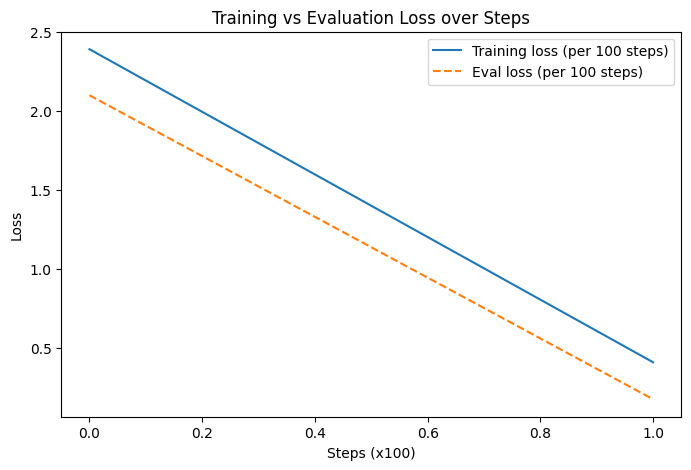

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(all_train_losses, label='Training loss (per 100 steps)')
plt.plot(all_eval_losses, label='Eval loss (per 100 steps)', linestyle='--')
plt.xlabel("Steps (x100)")
plt.ylabel("Loss")
plt.title("Training vs Evaluation Loss over Steps")
plt.legend()
plt.show()

#### **Evaluating the BERT Model**

Now that we've trained our model, we can evaluate its performance on the held-out test set (which is 20% of the data). Note that here, no gradient updates are performed, the model just outputs its logits.

In [33]:
import torch
from tqdm import tqdm

def predict(model, dataloader, device, ids_to_labels):
    """
    Generate predictions and ground truth labels for a token classification model.

    Args:
        model: Trained HuggingFace model (e.g., BertForTokenClassification)
        dataloader: DataLoader providing batches with 'input_ids', 'attention_mask', and 'labels'
        device: torch.device('cuda' or 'cpu')
        ids_to_labels: dict mapping label IDs to label strings

    Returns:
        labels_list: List[List[str]] — true labels per sentence (excluding padding)
        predictions_list: List[List[str]] — predicted labels per sentence (excluding padding)
    """
    model.eval()
    labels_list = []
    predictions_list = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Predicting", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['token_targets']['NE-COARSE-LIT'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            for i in range(labels.size(0)):
                sentence_labels = labels[i]               # (seq_len,)
                sentence_logits = logits[i]               # (seq_len, num_labels)
                sentence_preds = torch.argmax(sentence_logits, dim=-1)

                # Filter out ignored tokens (-100)
                active_mask = sentence_labels != -100
                filtered_labels = sentence_labels[active_mask]
                filtered_preds = sentence_preds[active_mask]

                labels_list.append([
                    ids_to_labels[id.item()] for id in filtered_labels
                ])
                predictions_list.append([
                    ids_to_labels[id.item()] for id in filtered_preds
                ])

    return labels_list, predictions_list

NER is evaluated at the **entity level**, not just by individual tokens.  
That means a prediction is counted as **correct** only if:
- The predicted entity type (e.g. `pers`, `loc`, `org`) is correct, **and**
- The entity **span** (the full sequence of tokens forming the entity) exactly matches the true one.

This ensures that partial matches (like predicting only “Barack” in “Barack Obama”) are not overcounted.


In [35]:
labels, predictions = predict(model, test_loader, device, ids_to_labels)

In [36]:
from seqeval.metrics import classification_report

print(classification_report(labels, predictions, digits=4))

              precision    recall  f1-score   support

         loc     0.7554    0.8308    0.7913       721
         org     0.2759    0.1391    0.1850       115
        pers     0.6399    0.7440    0.6881       504
        prod     0.0000    0.0000    0.0000        41
        time     0.4107    0.4340    0.4220        53

   micro avg     0.6785    0.7064    0.6922      1434
   macro avg     0.4164    0.4296    0.4173      1434
weighted avg     0.6420    0.7064    0.6701      1434



/opt/anaconda3/envs/p11/lib/python3.11/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Here:
- `labels` → list of true IOB tags (e.g. `["B-pers", "I-pers", "O", ...]`)
- `predictions` → list of predicted IOB tags from the model


Performance already seems quite good, but note that we've only trained for 1 epoch. An optimal approach would be to perform evaluation on a validation set while training to improve generalization.

#### Predicting on Other Samples

This is a quick sanity check — to visually confirm that your model can tag entities correctly before running a full evaluation loop.


In [37]:
# Example: run prediction on a single sentence
example_sentence = "Napoléon Bonaparte est né à Ajaccio en 1769."
encoding = tokenizer(
    example_sentence,
    return_tensors="pt",
    truncation=True,
    max_length=MAX_LEN
).to(device)

model.eval()
with torch.no_grad():
    outputs = model(**encoding)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1).squeeze()

# Decode tokens and labels
tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())
predicted_labels = [ids_to_labels[p.item()] for p in predictions]

# Display tokens and predicted labels (excluding padding and special tokens)
for token, label in zip(tokens, predicted_labels):
    if token not in ["[PAD]", "[CLS]", "[SEP]"]:
        print(f"{token:15} {label}")

Napoléon        B-pers
Bonaparte       I-pers
est             O
né              O
à               O
Aj              B-loc
##ac            B-loc
##cio           I-loc
en              I-time
176             I-time
##9             I-time
.               O
